In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import datetime
from scipy.stats import norm
import random
from skimage.metrics import structural_similarity as ssim
from sklearn.mixture import GaussianMixture

c:\Users\joaki\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1

In [3]:
# Define parameters
amplitude = 5
frequency = 10  # Hz
duration = 0.5  # seconds
sampling_rate = 1000  # samples per second
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define Fourier Transform plotting function
def plot_signal_and_fft(signal, title, xlabel='Time (s)', ylabel='Amplitude (V)'):
    # Compute Fourier Transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]

    # Plot time-domain and frequency-domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(t, signal)
    ax1.set_title(f"{title} - Time Domain")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
    ax2.set_title(f"{title} - Fourier Transform")
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    plt.tight_layout()
    plt.show()

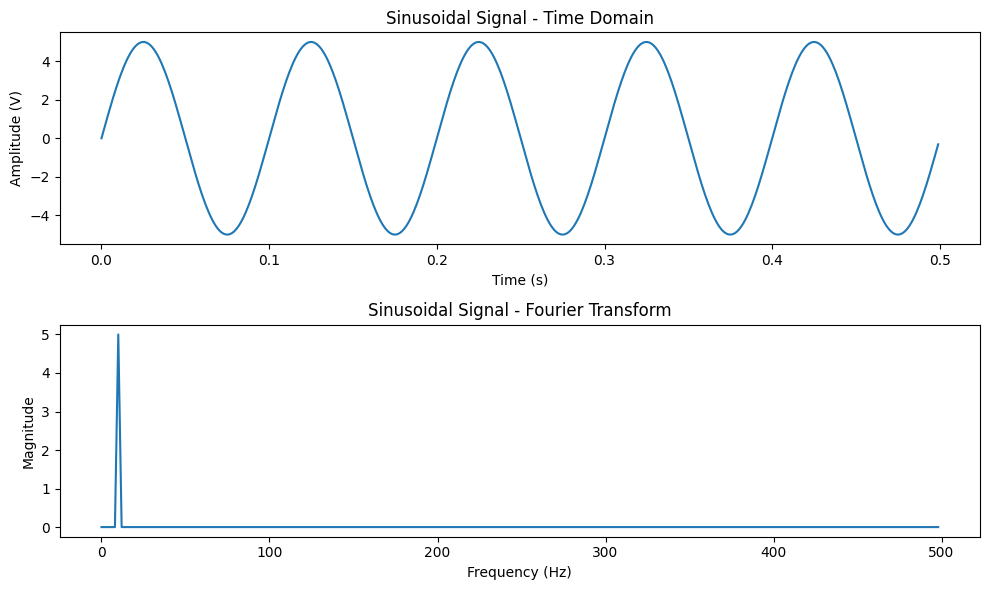

In [4]:
# (a) Sinusoidal Signal
sinusoidal_signal = amplitude * np.sin(2 * np.pi * frequency * t)
plot_signal_and_fft(sinusoidal_signal, "Sinusoidal Signal")

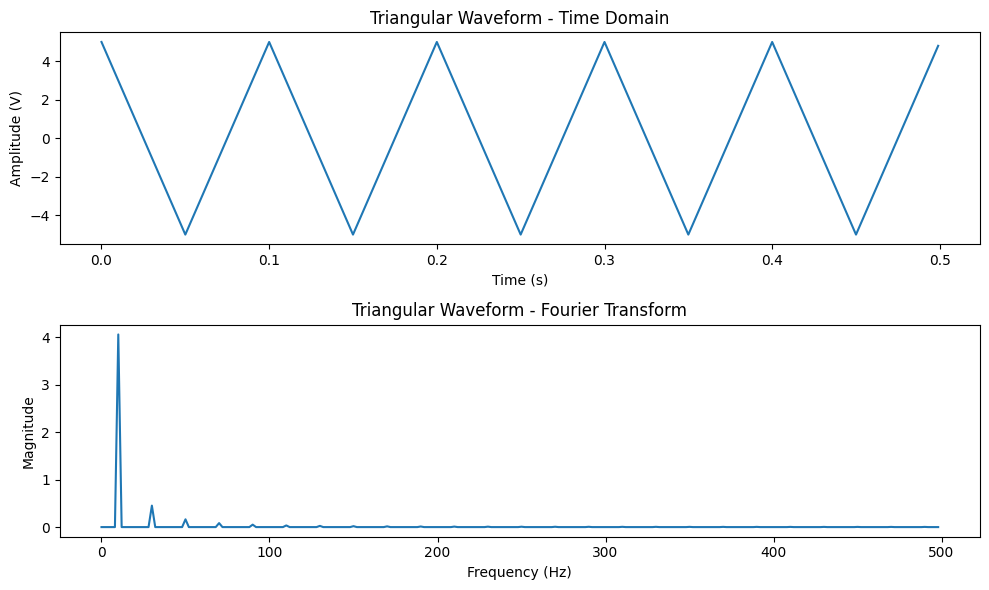

In [5]:
# (b) Triangular Waveform
triangular_signal = amplitude * np.abs(np.mod(t * frequency, 1) * 2 - 1) * 2 - amplitude
plot_signal_and_fft(triangular_signal, "Triangular Waveform")

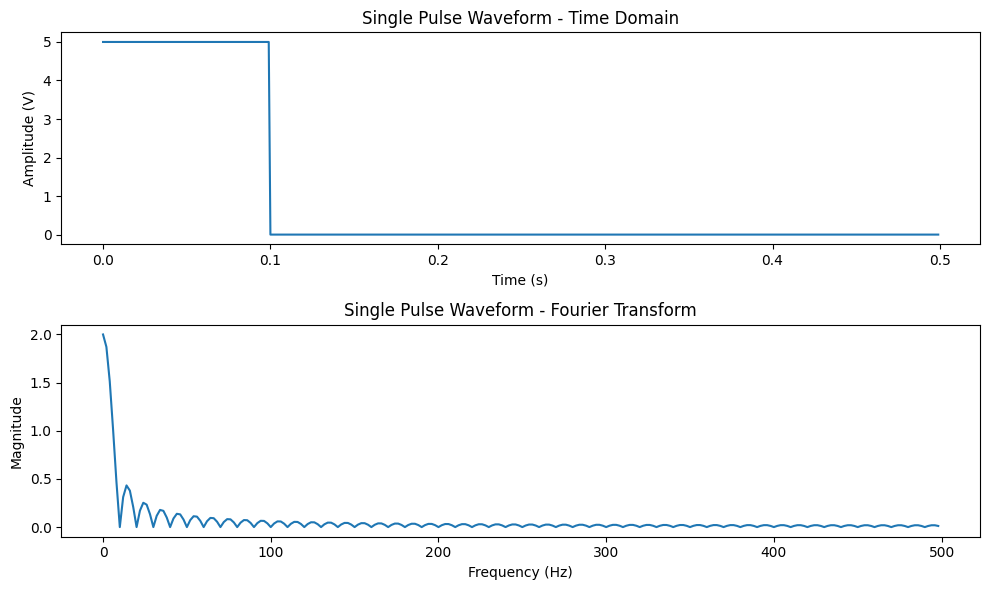

In [6]:
# (c) Single Pulse Waveform
pulse_single = np.zeros_like(t)
pulse_single[:int(0.2 * len(t))] = amplitude
plot_signal_and_fft(pulse_single, "Single Pulse Waveform")

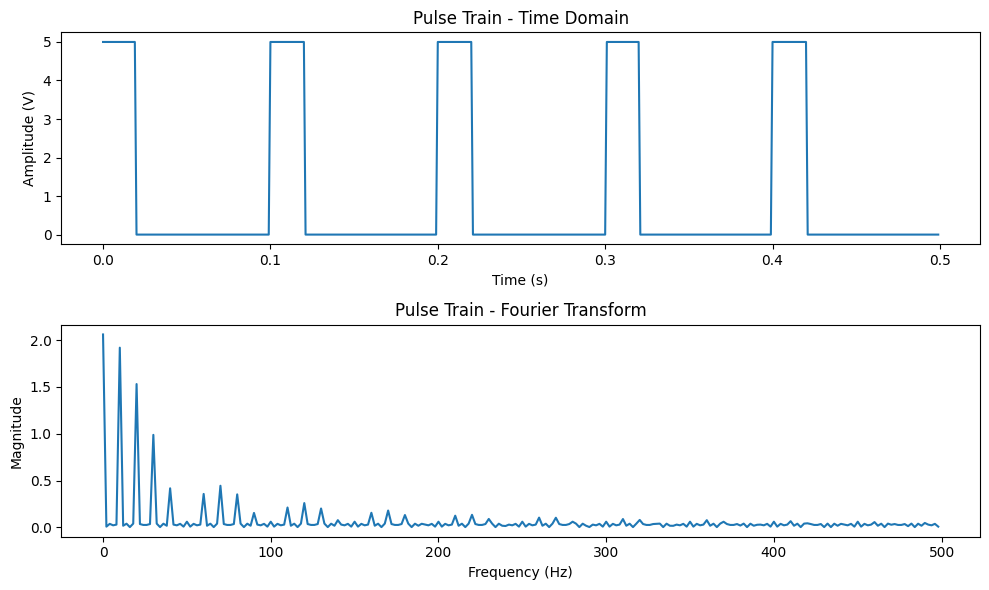

In [7]:
# (d) Pulse Train
pulse_train = (np.mod(t, 0.1) < 0.02).astype(float) * amplitude
plot_signal_and_fft(pulse_train, "Pulse Train")

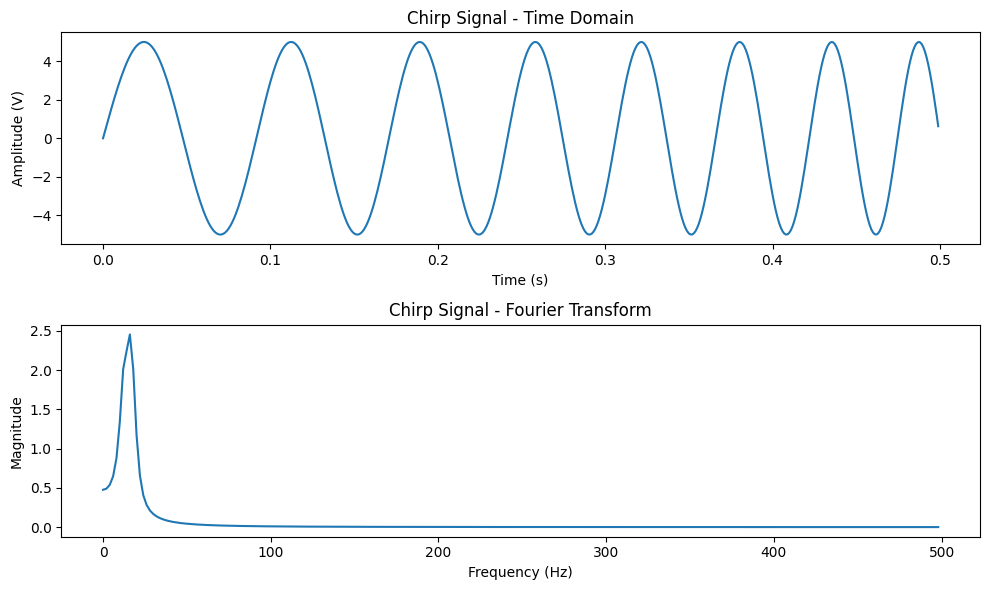

In [8]:
# (e) Chirp Signal
chirp_signal = amplitude * np.sin(2 * np.pi * (10 * t + (20 - 10) / (2 * duration) * t**2))
plot_signal_and_fft(chirp_signal, "Chirp Signal")

# Question 2

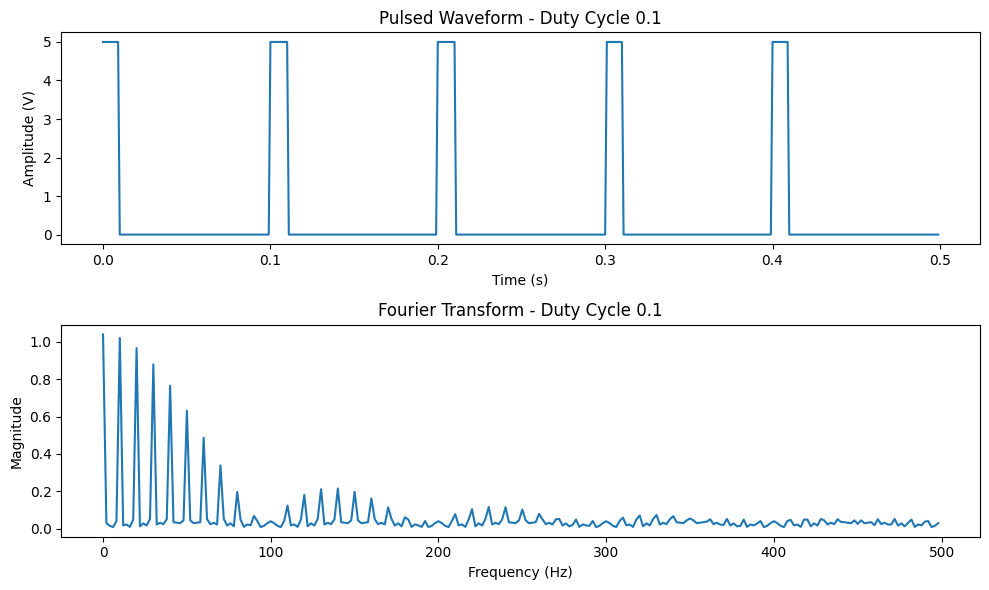

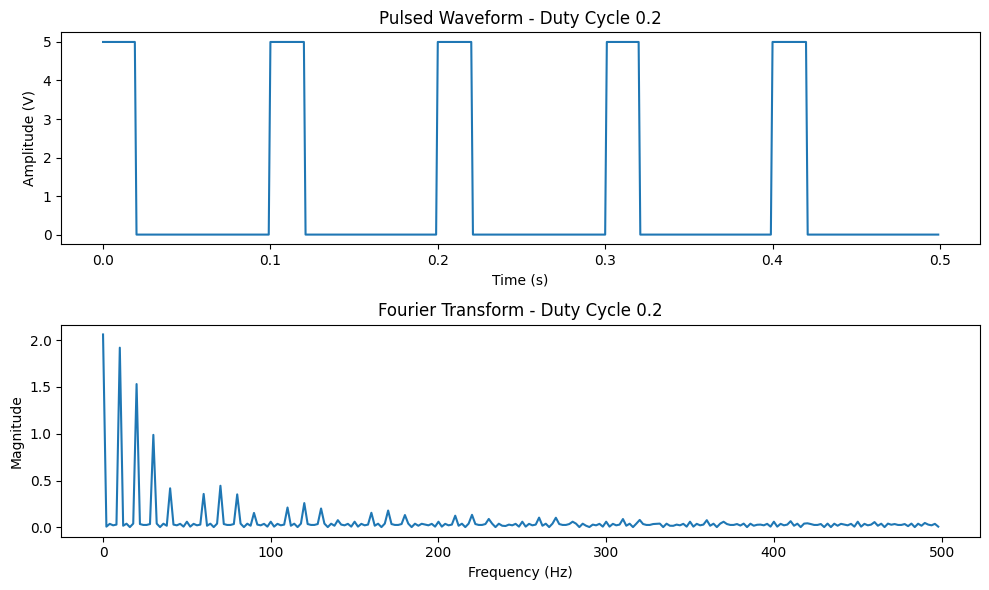

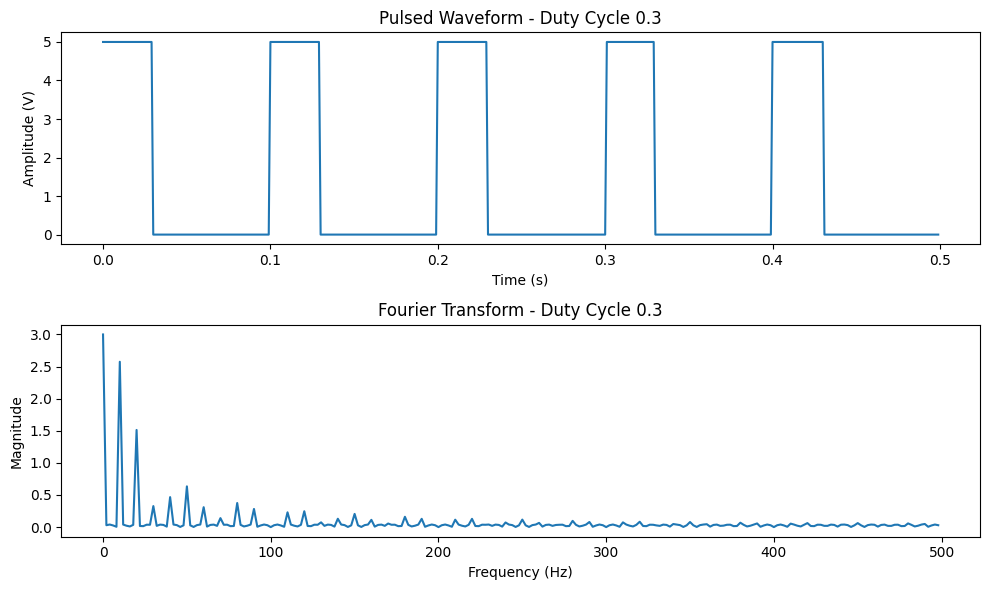

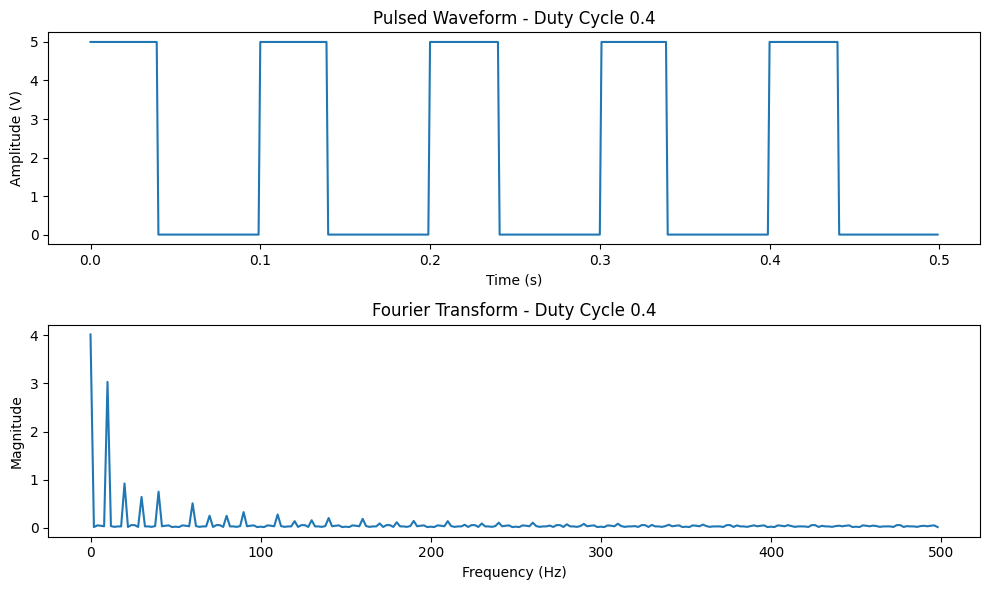

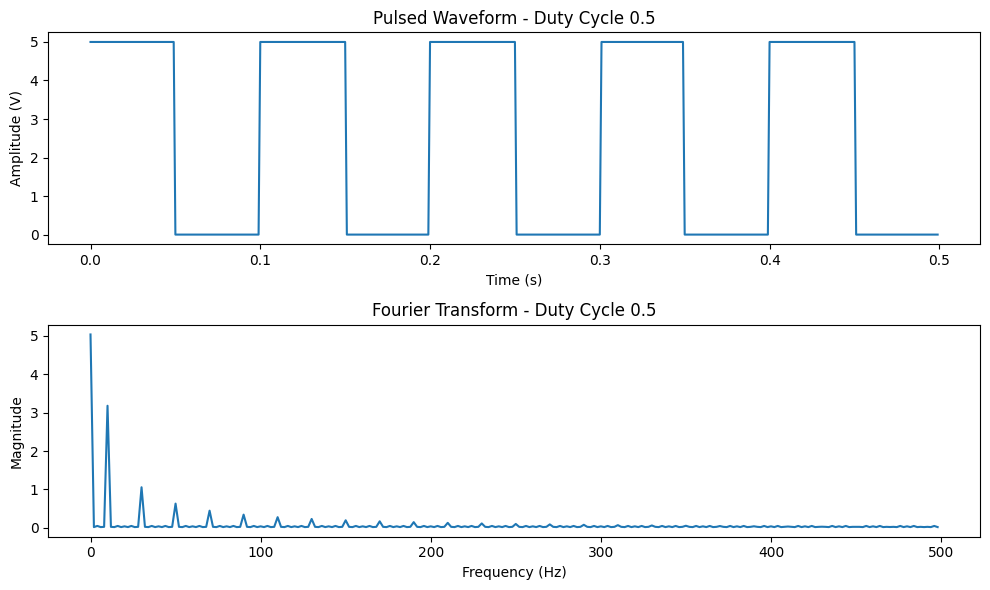

In [9]:
# Define parameters for pulsed waveform with different duty cycles
amplitude = 5
frequency = 10  # Hz
duration = 0.5  # seconds
sampling_rate = 1000  # samples per second
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Duty cycles to test
duty_cycles = [0.1, 0.2, 0.3, 0.4, 0.5]

# Function to generate a pulsed waveform based on duty cycle and plot
def plot_pulse_waveform_duty_cycle(duty_cycle):
    # Generate pulse train for given duty cycle
    pulse_waveform = (np.mod(t, 1/frequency) < duty_cycle/frequency).astype(float) * amplitude

    # Compute Fourier Transform
    N = len(pulse_waveform)
    yf = fft(pulse_waveform)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]

    # Plot time-domain and frequency-domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(t, pulse_waveform)
    ax1.set_title(f"Pulsed Waveform - Duty Cycle {duty_cycle}")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude (V)")

    ax2.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
    ax2.set_title(f"Fourier Transform - Duty Cycle {duty_cycle}")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Magnitude")
    plt.tight_layout()
    plt.show()

# Plot for each duty cycle
for duty_cycle in duty_cycles:
    plot_pulse_waveform_duty_cycle(duty_cycle)


# Question 3

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 58, 173, 32)       896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 29, 86, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 27, 84, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 13, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 11, 40, 128)       73856  

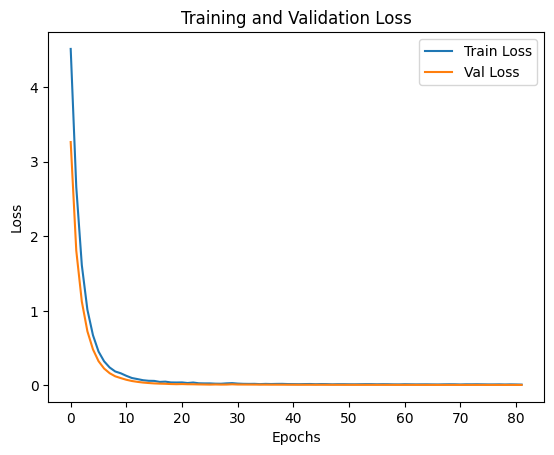

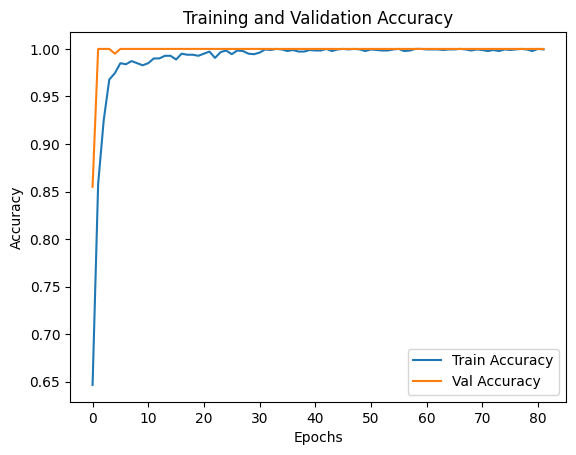

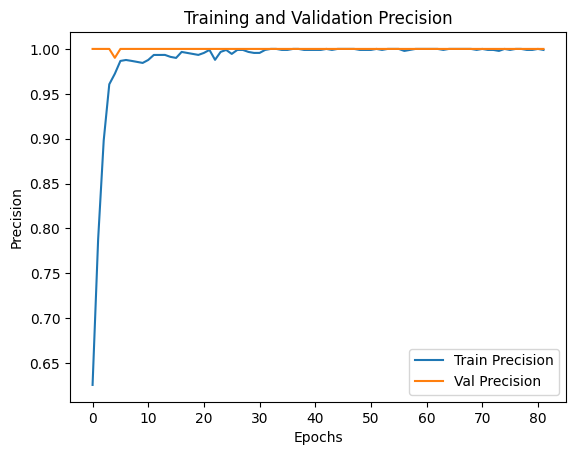

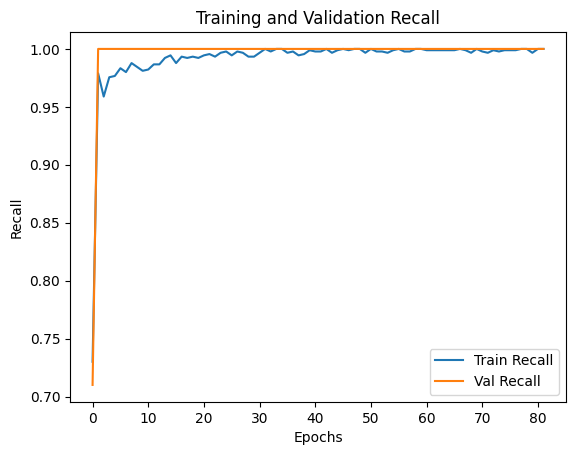

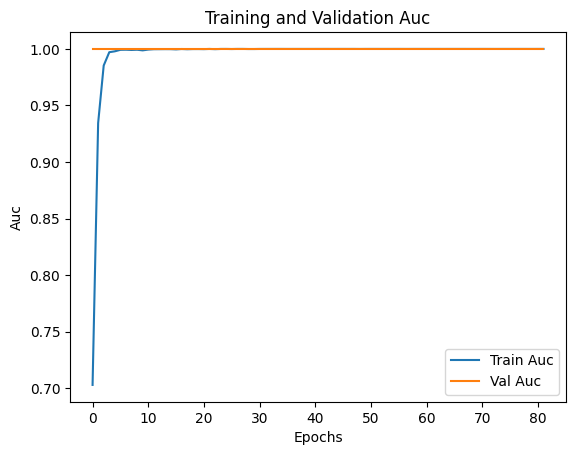

7/7 [==============================] - 0s 33ms/step


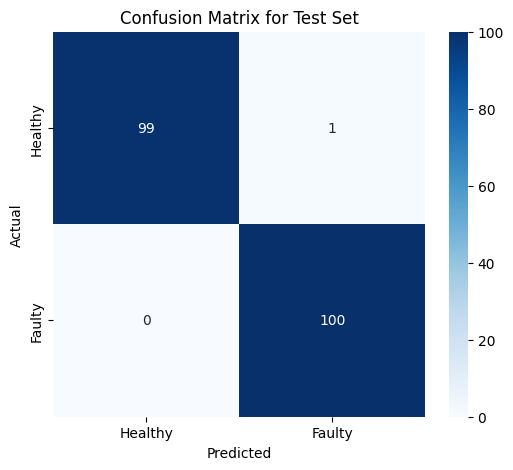

              precision    recall  f1-score   support

     Healthy       1.00      0.99      0.99       100
      Faulty       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [ ]:
# Define paths
train_directory = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\training"
val_directory = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\validation"
test_directory = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\testing"

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# %% [markdown]
# ### 3. Set Up Data Generators with Augmentation for Training

# %%
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# For validation and test sets, no augmentation, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary'
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    val_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary'
)

# Test generator (without shuffling to preserve order for evaluation)
test_generator = val_test_datagen.flow_from_directory(
    test_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# %% [markdown]
# ### 4. Define CNN Model with Regularization, Dropout, and Custom Metrics

# %%
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 175, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=METRICS)

model.summary()

# %% [markdown]
# ### 5. Configure Callbacks and Train the Model

# %%
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
)

# %% [markdown]
# ### 6. Plot Training and Validation Metrics

# %%
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_metrics(history)

# %% [markdown]
# ### 7. Evaluate Model on Test Set and Display Confusion Matrix

# %%
# Predict on test set
y_test_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()
y_test_true = test_generator.classes

# Confusion matrix
conf_mat_test = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report for test set
print(classification_report(y_test_true, y_test_pred, target_names=['Healthy', 'Faulty']))

# %% [markdown]
# ### 8. Save and Load Model if Needed

# %%
# Save model
model.save("fault_classification_model.h5")

# Load model (optional)
# model = tf.keras.models.load_model("fault_classification_model.h5")

# Question 4

Epoch 1/100
66/66 [==============================] - 1s 8ms/step - loss: 1.6627 - accuracy: 0.7324 - val_loss: 1.8983 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 2/100
66/66 [==============================] - 0s 6ms/step - loss: 1.0534 - accuracy: 0.9262 - val_loss: 1.8964 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 3/100
66/66 [==============================] - 0s 6ms/step - loss: 0.9594 - accuracy: 0.9567 - val_loss: 1.8356 - val_accuracy: 0.6356 - lr: 1.0000e-04
Epoch 4/100
66/66 [==============================] - 0s 6ms/step - loss: 0.9349 - accuracy: 0.9629 - val_loss: 1.6622 - val_accuracy: 0.6622 - lr: 1.0000e-04
Epoch 5/100
66/66 [==============================] - 0s 6ms/step - loss: 0.8968 - accuracy: 0.9729 - val_loss: 1.3485 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 6/100
66/66 [==============================] - 0s 6ms/step - loss: 0.8570 - accuracy: 0.9776 - val_loss: 1.0502 - val_accuracy: 0.9756 - lr: 1.0000e-04
Epoch 7/100
66/66 [==============================] -

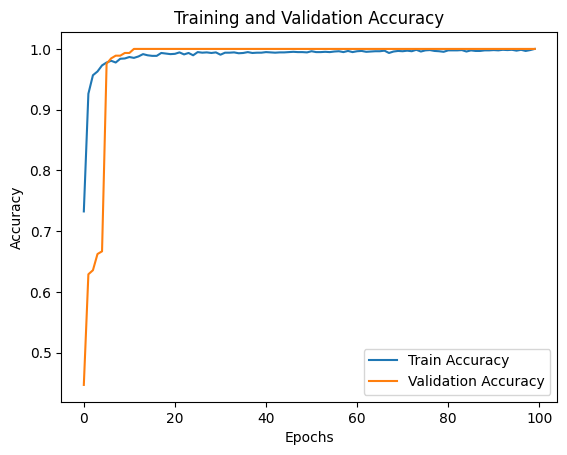

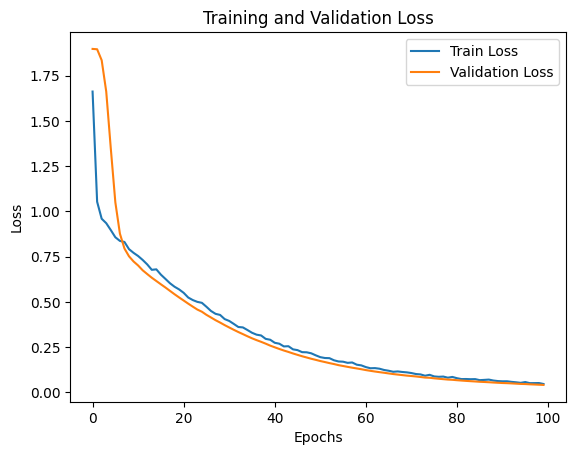

15/15 [==============================] - 0s 2ms/step


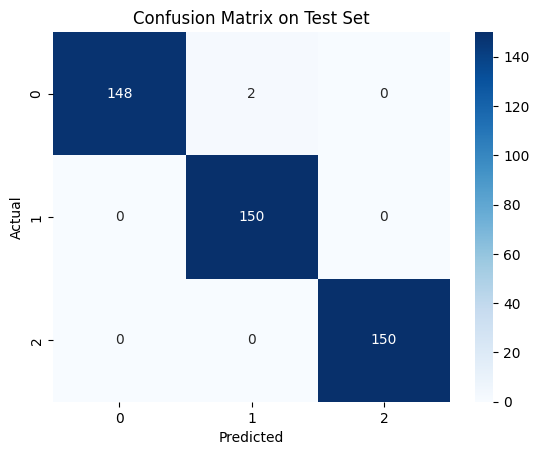

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       0.99      1.00      0.99       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



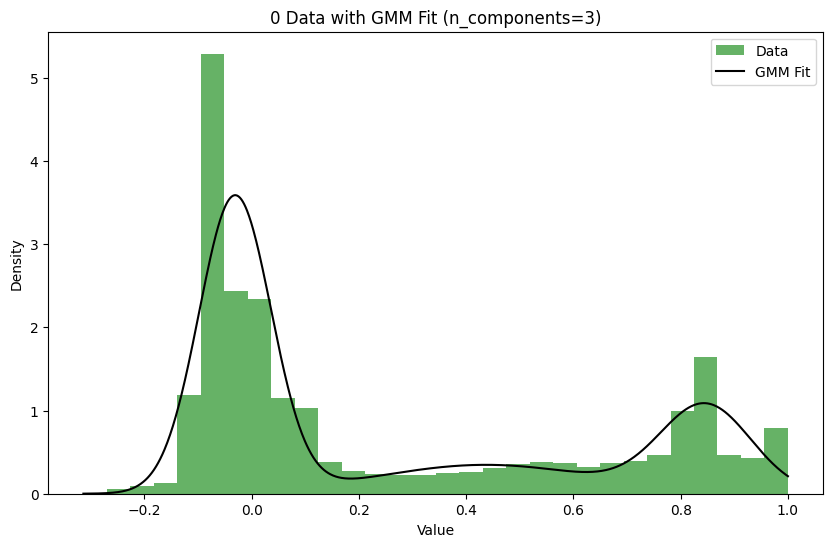

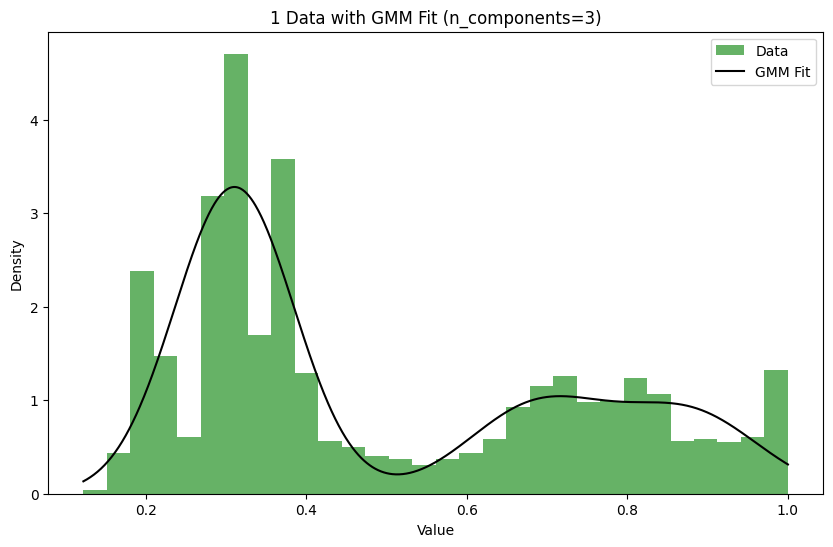

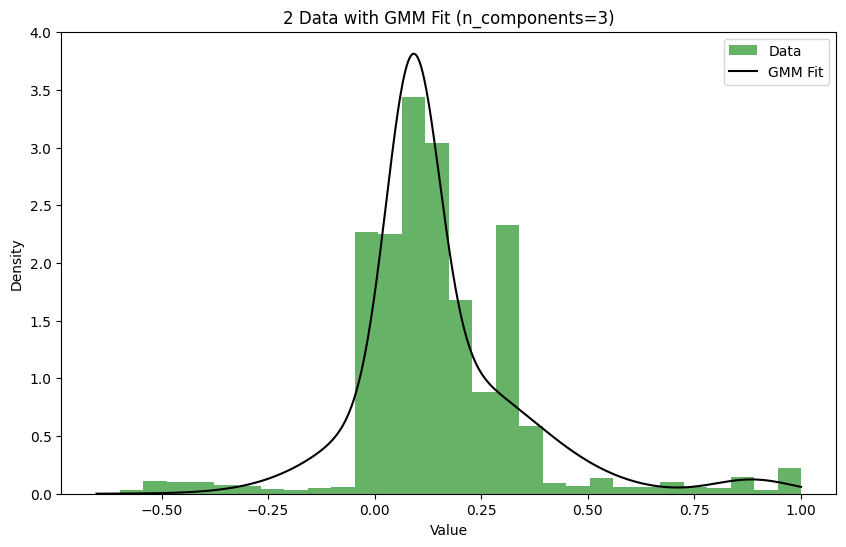

In [ ]:
# Load dataset
data = pd.read_csv('data_cotton_wool_polyester.csv')
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize the data with a consistent max value across all datasets
max_val = np.max(X_train)
X_train = X_train / max_val
X_val = X_val / max_val
X_test = X_test / max_val

# Reshape data to fit the 1D CNN input format
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Encode labels
encoder = LabelEncoder()
y_train_enc = to_categorical(encoder.fit_transform(y_train))
y_val_enc = to_categorical(encoder.transform(y_val))
y_test_enc = to_categorical(encoder.transform(y_test))

# Define the 1D CNN Model
model = models.Sequential([
    layers.Conv1D(16, 3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.4),
    
    layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train_enc,
    epochs=100,
    validation_data=(X_val, y_val_enc),
    callbacks=[early_stopping, lr_scheduler]
)

# Plot Training and Validation Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on test data and display confusion matrix
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test_enc, axis=1)

conf_mat = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

print(classification_report(y_test_true, y_test_pred, target_names=[str(label) for label in encoder.classes_]))

# Gaussian Mixture Model Fitting Function with Multiple Components
def plot_gmm_fit(data, label, n_components=3):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data.reshape(-1, 1))
    
    x = np.linspace(data.min(), data.max(), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')
    plt.plot(x, pdf, 'k-', label='GMM Fit')
    
    plt.title(f'{label} Data with GMM Fit (n_components={n_components})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    return [(mean, np.sqrt(cov)) for mean, cov in zip(gmm.means_.flatten(), gmm.covariances_.flatten())]

# Fit GMM and plot for each class
class_labels = encoder.classes_
gaussian_params = {}
for label in class_labels:
    data = X[y == label].flatten()
    gaussian_params[label] = plot_gmm_fit(data, label, n_components=3)


Epoch 1/100
75/75 [==============================] - 1s 5ms/step - loss: 1.3230 - accuracy: 0.4944 - val_loss: 1.9581 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 1.0667 - accuracy: 0.5828 - val_loss: 2.5707 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 0.8791 - accuracy: 0.6854 - val_loss: 3.4171 - val_accuracy: 0.0250 - lr: 5.0000e-04
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7797 - accuracy: 0.7430 - val_loss: 3.8621 - val_accuracy: 0.4133 - lr: 5.0000e-04
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.7818 - val_loss: 4.3988 - val_accuracy: 0.4450 - lr: 5.0000e-04
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.7872 - val_loss: 4.4076 - val_accuracy: 0.4450 - lr: 5.0000e-04
Epoch 7/100
75/75 [=========================

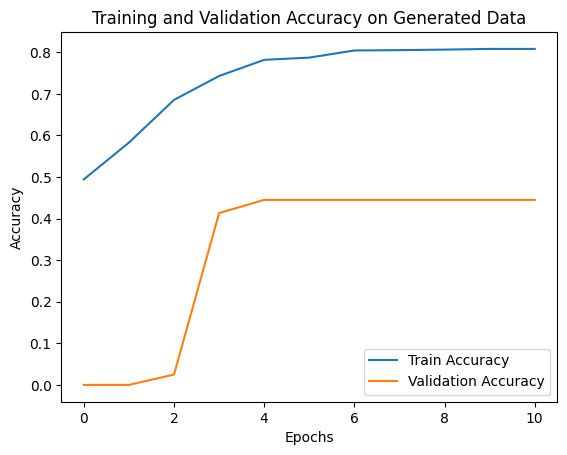

15/15 [==============================] - 0s 1ms/step


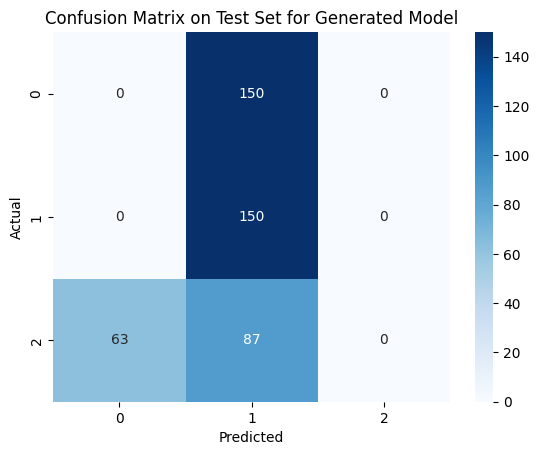

In [20]:
# Generate synthetic data based on Gaussian parameters (assuming gaussian_params is defined)
generated_data = []
generated_labels = []
for label, components in gaussian_params.items():
    for mean, std in components:
        component_data = np.random.normal(mean, std, (333, X_train.shape[1]))
        generated_data.append(component_data)
        generated_labels.extend([label] * 333)

# Convert generated data and labels to arrays and reshape
X_generated = np.vstack(generated_data)[..., np.newaxis]
y_generated = np.array(generated_labels)

# Encode generated labels
y_generated_enc = to_categorical(encoder.transform(y_generated))

# Define a simpler model for generated data with increased regularization and reduced complexity
generated_model = models.Sequential([
    layers.Conv1D(8, 3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(2),
    layers.Conv1D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),  # Increased dropout rate for stronger regularization
    layers.Dense(3, activation='softmax')
])

# Compile with a lower learning rate and a learning rate scheduler
generated_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks: EarlyStopping and ReduceLROnPlateau for dynamic learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model on generated data
history_generated = generated_model.fit(
    X_generated, y_generated_enc,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Plot Training and Validation Accuracy for Generated Data
plt.plot(history_generated.history['accuracy'], label='Train Accuracy')
plt.plot(history_generated.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy on Generated Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data and display confusion matrix
y_generated_pred = np.argmax(generated_model.predict(X_test), axis=1)
conf_mat_generated = confusion_matrix(y_test_true, y_generated_pred)
sns.heatmap(conf_mat_generated, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set for Generated Model')
plt.show()


# Question 5

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/30
57/57 [==============================] - 27s 457ms/step - loss: 0.0411 - val_loss: 0.0369 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - 29s 505ms/step - loss: 0.0183 - val_loss: 0.0091 - lr: 0.0010
Epoch 3/30
57/57 [==============================] - 29s 507ms/step - loss: 0.0051 - val_loss: 0.0052 - lr: 0.0010
Epoch 4/30
57/57 [==============================] - 27s 474ms/step - loss: 0.0034 - val_loss: 0.0046 - lr: 0.0010
Epoch 5/30
57/57 [==============================] - 28s 492ms/step - loss: 0.0025 - val_loss: 0.0031 - lr: 0.0010
Epoch 6/30
57/57 [==============================] - 30s 530ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/30
57/57 [==============================] - 29s 506ms/step - loss: 0.0016 - val_loss: 0.0020 - lr: 0.0010
Epoch 8/30
57/57 [==============================] - 27s 474ms/step - loss: 0.0

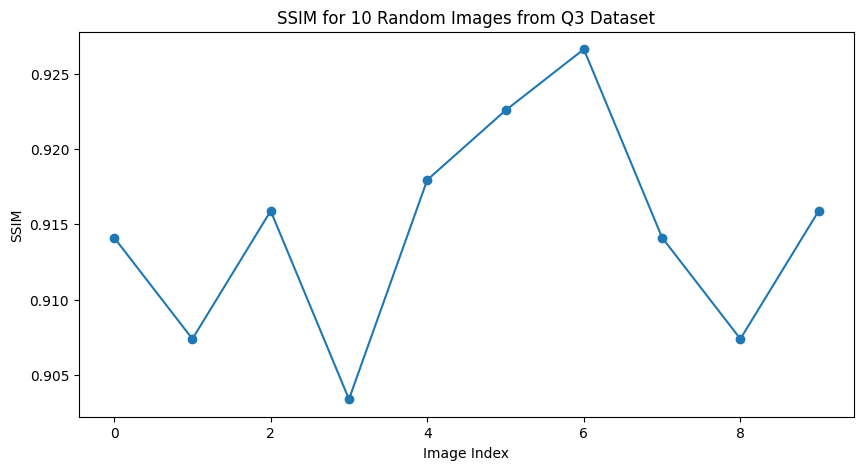

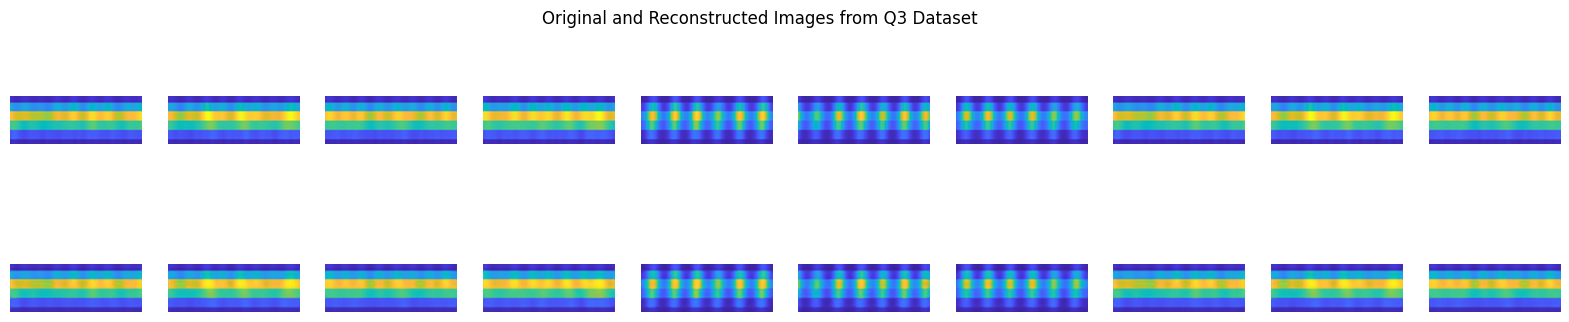

In [17]:
# Define paths
train_directory_q3 = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\training"
val_directory_q3 = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\validation"
test_directory_q3 = r"C:\Users\joaki\OneDrive\Dokumenter\Skole\Assignments_MAS512\Data_fault_classification\testing"

# Common rescale value for consistent normalization
rescale_value = 1./255

# Data augmentation for Q3 dataset
train_datagen_q3 = ImageDataGenerator(
    rescale=rescale_value,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# No augmentation for validation and test sets, only rescaling
val_test_datagen_q3 = ImageDataGenerator(rescale=rescale_value)

# Data generators for Q3 dataset
train_generator_q3 = train_datagen_q3.flow_from_directory(
    train_directory_q3,
    target_size=(64, 175),
    batch_size=32,
    class_mode='input'
)

val_generator_q3 = val_test_datagen_q3.flow_from_directory(
    val_directory_q3,
    target_size=(64, 175),
    batch_size=32,
    class_mode='input'
)

test_generator_q3 = val_test_datagen_q3.flow_from_directory(
    test_directory_q3,
    target_size=(64, 175),
    batch_size=32,
    class_mode='input',
    shuffle=False
)

# Define Autoencoder Model with controlled shape adjustments
def build_autoencoder(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Downsample to (30, 88)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Downsample to (15, 44)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Downsample to (8, 22)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)  # Upsample to (15, 44)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Upsample to (30, 88)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Upsample to (60, 176)

    # Adjust final dimensions with cropping to match input shape exactly
    x = layers.Cropping2D(((0, 0), (1, 0)))(x)  # Crop 1 pixel from width if needed
    decoded = layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    return autoencoder

# Initialize and Train Autoencoder on Q3 dataset
autoencoder_q3 = build_autoencoder((64, 175, 3))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
log_dir = "logs_q3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history_q3 = autoencoder_q3.fit(
    train_generator_q3,
    epochs=30,
    validation_data=val_generator_q3,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
)

# Function to compute SSIM for a set of images
def compute_ssim(x, x_reconstructed, win_size=3):
    ssim_values = [
        ssim(original, recon, data_range=1.0, win_size=win_size, channel_axis=-1) 
        for original, recon in zip(x, x_reconstructed)
    ]
    return ssim_values

# Evaluate Q3 dataset autoencoder on a subset of test images
num_images = 10  # Number of images to evaluate
test_images_q3 = []
for _ in range(num_images):
    batch = next(test_generator_q3)
    test_images_q3.append(batch[0][0])  # Take one image from the batch

test_images_q3 = np.array(test_images_q3)
reconstructed_images_q3 = autoencoder_q3.predict(test_images_q3)
ssim_values_q3 = compute_ssim(test_images_q3, reconstructed_images_q3, win_size=3)

# Plot SSIM values for Q3 dataset
plt.figure(figsize=(10, 5))
plt.plot(ssim_values_q3, marker='o')
plt.title("SSIM for 10 Random Images from Q3 Dataset")
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.show()

# Display Original and Reconstructed Images for Q3 dataset
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(test_images_q3[i])
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images_q3[i])
    axes[1, i].axis("off")
plt.suptitle("Original and Reconstructed Images from Q3 Dataset")
plt.show()